In [37]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import statsmodels.stats.api as sms
import matplotlib as mpl
import seaborn as sns
import matplotlib.pyplot as plt
from math import ceil


%matplotlib inline

In [31]:
effect_size = sms.proportion_effectsize(0.13, 0.15)    # Calculating effect size based on our expected rates

required_n = sms.NormalIndPower().solve_power(
    effect_size, 
    power=0.8, 
    alpha=0.05, 
    ratio=1
    )                                                  # Calculating sample size needed

required_n = ceil(required_n)                          # Rounding up to next whole number                          

print(required_n)

4720


In [2]:
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [4]:
df.shape

(294478, 5)

In [ ]:
df.info()

In [6]:
users_unique = df.user_id.nunique()
users_unique

290584

In [7]:
# proportions of user who converted
df[df.converted == 1].user_id.count()/df.shape[0]

0.11965919355605512

In [8]:
#the number of times the new_page and treatment don't line up
#1.number where new_page group to control
#2.number where old_page group to treatment
df[(df.landing_page == 'new_page') & (df.group != 'treatment')].user_id.count() + df[(df.landing_page != 'new_page') & (df.group == 'treatment')].user_id.count()

3893

In [9]:
#the rows have missing values
df.isnull().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

In [10]:
df2 = df.drop(df[((df.landing_page == 'new_page') & (df.group != 'treatment')) | ((df.landing_page != 'new_page') & (df.group == 'treatment'))].index)
df2

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1
...,...,...,...,...,...
294473,751197,2017-01-03 22:28:38.630509,control,old_page,0
294474,945152,2017-01-12 00:51:57.078372,control,old_page,0
294475,734608,2017-01-22 11:45:03.439544,control,old_page,0
294476,697314,2017-01-15 01:20:28.957438,control,old_page,0


In [11]:
#double check all the correct rows were removed
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

In [12]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 290585 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       290585 non-null  int64 
 1   timestamp     290585 non-null  object
 2   group         290585 non-null  object
 3   landing_page  290585 non-null  object
 4   converted     290585 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 13.3+ MB


In [13]:
df2.user_id.nunique()


290584

In [14]:
df2.user_id[df2.user_id.duplicated(keep=False)]

1899    773192
2893    773192
Name: user_id, dtype: int64

In [16]:
df2[df2.user_id.duplicated(keep= False)]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


In [17]:
#remove duplicate row
df2 = df2[df2.timestamp != '2017-01-09 05:37:58.781806']

In [18]:
df2.user_id.nunique()

290584

In [19]:
# What is the probability of an individual converting regardless of the page they receive?
df2.converted.mean()


0.11959708724499628

In [20]:
#Given that an individual was in the control group, what is the probability they converted?
df2.converted[df2.group == 'control'].mean()

0.1203863045004612

In [21]:
#Given that an individual was in the treatment group, what is the probability they converted?
df2.converted[df2.group == 'treatment'].mean()

0.11880806551510564

In [22]:
#What is the probability that an individual received the new page?
df2[df2.landing_page == 'new_page'].count()/df2.shape[0]

user_id         0.500062
timestamp       0.500062
group           0.500062
landing_page    0.500062
converted       0.500062
dtype: float64

In [23]:
# convert rate is how many users converted (i.e. converted = 1)
p_new = df2.converted.mean()
p_new

0.11959708724499628

In [24]:
p_old = df2.converted.mean() # the same!!!
p_old

0.11959708724499628

In [25]:
# number of users who got the new page (i.e. group = treatment)
n_new = df2[df2.group == 'treatment'].count()[0]
n_new

145310

In [26]:
# number of users who reamined with old page (i.e. group = control)
n_old = df2[df2.group == 'control'].count()[0]
n_old

145274

In [27]:
import statsmodels.stats.api as sms

In [32]:
control_sample = df2[df2['group'] == 'control'].sample(n=required_n, random_state=22)
treatment_sample = df2[df2['group'] == 'treatment'].sample(n=required_n, random_state=22)

ab_test = pd.concat([control_sample, treatment_sample], axis=0)
ab_test.reset_index(drop=True, inplace=True)

In [33]:
ab_test

,user_id,timestamp,group,landing_page,converted
0,864622,2017-01-07 19:35:55.115584,control,old_page,0
1,931017,2017-01-20 22:24:11.980654,control,old_page,0
2,822759,2017-01-10 19:00:45.471182,control,old_page,0
3,715765,2017-01-19 23:16:23.269389,control,old_page,0
4,666686,2017-01-23 00:08:30.152180,control,old_page,0
...,...,...,...,...,...
9435,688017,2017-01-12 11:50:30.520706,treatment,new_page,0
9436,699383,2017-01-18 23:14:20.245360,treatment,new_page,0
9437,724124,2017-01-13 18:12:31.235765,treatment,new_page,0
9438,695345,2017-01-13 20:57:14.879484,treatment,new_page,0


In [34]:
ab_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9440 entries, 0 to 9439
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   user_id       9440 non-null   int64 
 1   timestamp     9440 non-null   object
 2   group         9440 non-null   object
 3   landing_page  9440 non-null   object
 4   converted     9440 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 368.9+ KB


In [35]:
ab_test['group'].value_counts()

control      4720
treatment    4720
Name: group, dtype: int64

In [38]:
conversion_rates = ab_test.groupby('group')['converted']

std_p = lambda x: np.std(x, ddof=0)              # Std. deviation of the proportion
se_p = lambda x: stats.sem(x, ddof=0)            # Std. error of the proportion (std / sqrt(n))

conversion_rates = conversion_rates.agg([np.mean, std_p, se_p])
conversion_rates.columns = ['conversion_rate', 'std_deviation', 'std_error']


conversion_rates.style.format('{:.3f}')


,conversion_rate,std_deviation,std_error
group,,,
control,0.120,0.325,0.005
treatment,0.118,0.322,0.005


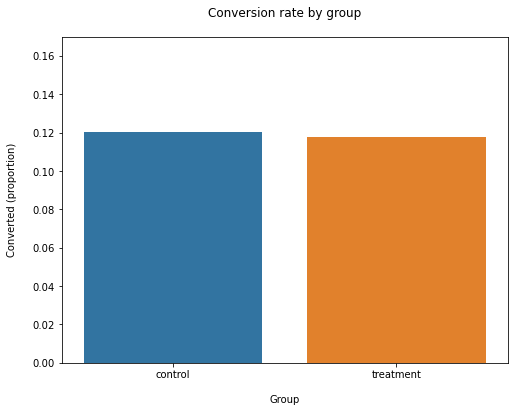

In [39]:
plt.figure(figsize=(8,6))

sns.barplot(x=ab_test['group'], y=ab_test['converted'], ci=False)

plt.ylim(0, 0.17)
plt.title('Conversion rate by group', pad=20)
plt.xlabel('Group', labelpad=15)
plt.ylabel('Converted (proportion)', labelpad=15);

In [40]:
from statsmodels.stats.proportion import proportions_ztest, proportion_confint

In [41]:
control_results = ab_test[ab_test['group'] == 'control']['converted']
treatment_results = ab_test[ab_test['group'] == 'treatment']['converted']

In [42]:
n_con = control_results.count()
n_treat = treatment_results.count()
successes = [control_results.sum(), treatment_results.sum()]
nobs = [n_con, n_treat]

z_stat, pval = proportions_ztest(successes, nobs=nobs)
(lower_con, lower_treat), (upper_con, upper_treat) = proportion_confint(successes, nobs=nobs, alpha=0.05)

print(f'z statistic: {z_stat:.2f}')
print(f'p-value: {pval:.3f}')
print(f'ci 95% for control group: [{lower_con:.3f}, {upper_con:.3f}]')
print(f'ci 95% for treatment group: [{lower_treat:.3f}, {upper_treat:.3f}]')

z statistic: 0.38
p-value: 0.703
ci 95% for control group: [0.111, 0.130]
ci 95% for treatment group: [0.109, 0.127]
